In [1]:
import pandas as pd
pd.reset_option('display.float_format')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from scipy import stats

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
filepath = "kc_house_data_NaN.csv"
df = pd.read_csv(filepath, header = 0)
df.drop(["Unnamed: 0", "id"], axis=1, inplace=True)
df['date'] = df['date'].map(lambda x: x.rstrip('T000000'))
df.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,221900.0,3.0,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209,538000.0,3.0,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  object 
 1   price          21613 non-null  float64
 2   bedrooms       21600 non-null  float64
 3   bathrooms      21603 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

In [7]:
mean_bed = df["bedrooms"].mean(axis=0)
mean_bath = df["bathrooms"].mean(axis=0)
df.replace({"bedrooms": {np.nan: mean_bed}, "bathrooms": {np.nan: mean_bath}}, inplace=True)

df[["bedrooms", "bathrooms"]].isnull().sum()

bedrooms     0
bathrooms    0
dtype: int64

In [9]:
df[["bedrooms", "bathrooms"]] = df[["bedrooms", "bathrooms"]].astype("int64")

In [11]:
df.describe(include="object")

,date
count,21613
unique,372
top,20140623
freq,142


In [13]:
df._get_numeric_data().corr()["price"].sort_values()

zipcode         -0.053203
long             0.021626
condition        0.036362
yr_built         0.054012
sqft_lot15       0.082447
sqft_lot         0.089661
yr_renovated     0.126434
floors           0.256794
waterfront       0.266369
lat              0.307003
bedrooms         0.308868
sqft_basement    0.323816
view             0.397293
bathrooms        0.510413
sqft_living15    0.585379
sqft_above       0.605567
grade            0.667434
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

In [15]:
for i in df._get_numeric_data().columns.values.tolist():
    c, p = stats.pearsonr(df[i], df["price"])
    print(f"{i}\nCoef:{c}\nP-value:{p}\n")

price
Coef:1.0
P-value:0.0

bedrooms
Coef:0.3088678795530152
P-value:0.0

bathrooms
Coef:0.5104128122357338
P-value:0.0

sqft_living
Coef:0.7020350546118
P-value:0.0

sqft_lot
Coef:0.08966086058710011
P-value:7.972504510431418e-40

floors
Coef:0.2567938875507184
P-value:1.6e-322

waterfront
Coef:0.26636943403060215
P-value:0.0

view
Coef:0.39729348829450417
P-value:0.0

condition
Coef:0.03636178912899755
P-value:8.93565406245874e-08

grade
Coef:0.6674342560202371
P-value:0.0

sqft_above
Coef:0.605567298356078
P-value:0.0

sqft_basement
Coef:0.3238160207119839
P-value:0.0

yr_built
Coef:0.05401153149479272
P-value:1.9298728094030873e-15

yr_renovated
Coef:0.12643379344089295
P-value:1.0213478858180941e-77

zipcode
Coef:-0.05320285429832561
P-value:5.011050503390596e-15

lat
Coef:0.30700347999521865
P-value:0.0

long
Coef:0.0216262410393067
P-value:0.00147509220633629

sqft_living15
Coef:0.585378903579568
P-value:0.0

sqft_lot15
Coef:0.08244715251948598
P-value:6.417559889421439e-34



Text(0.5, 0, 'Number of Bathrooms')

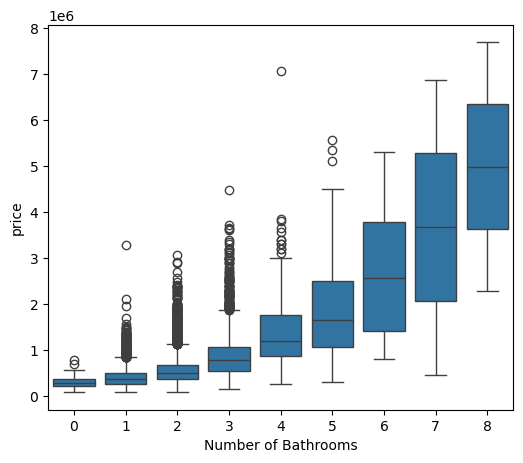

In [17]:
plt.figure(figsize=(6,5))
sns.boxplot(x="bathrooms", y="price", data=df)
plt.xlabel("Number of Bathrooms")

Text(0.5, 0, 'Number of Bedrooms')

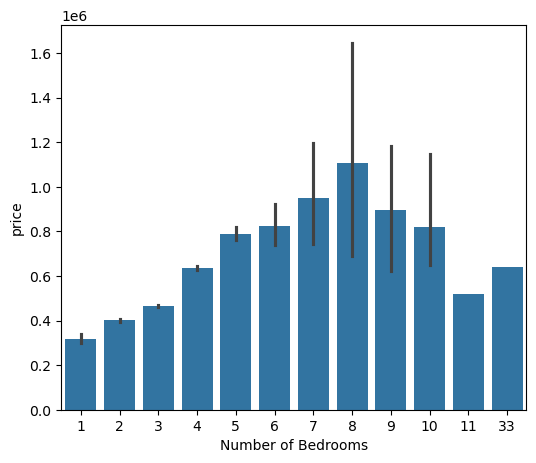

In [18]:
plt.figure(figsize=(6,5))
sns.barplot(x="bedrooms", y="price", data=df)
plt.xlabel("Number of Bedrooms")

<Axes: xlabel='sqft_living', ylabel='price'>

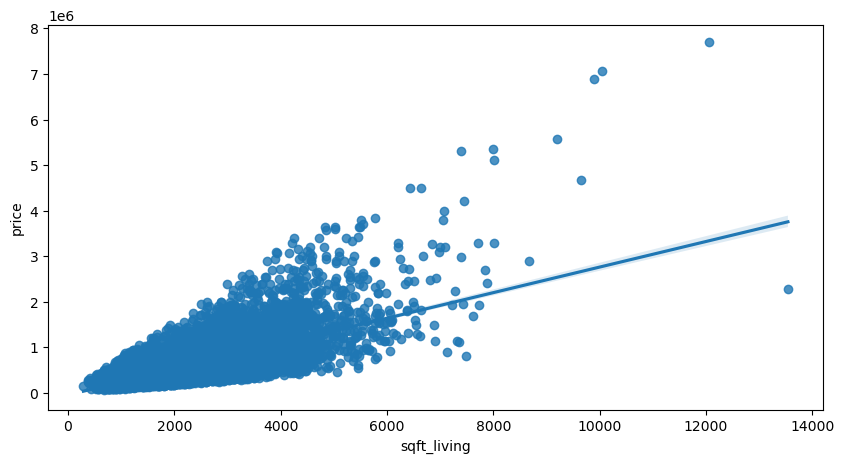

In [21]:
plt.figure(figsize=(10,5))
sns.regplot(x="sqft_living", y="price", data=df)

<Axes: xlabel='grade', ylabel='price'>

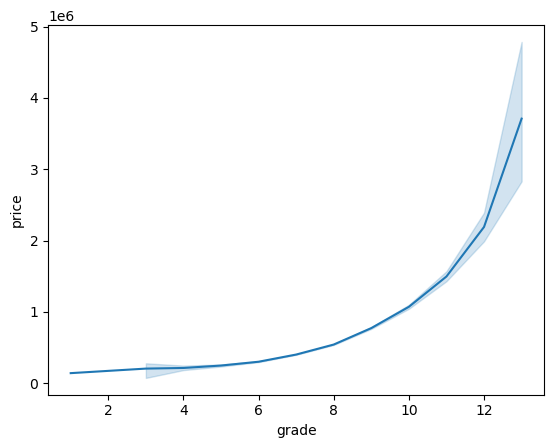

In [22]:
sns.lineplot(x="grade", y="price", data=df)

In [25]:
lr = LinearRegression()
y_data = df["price"]
x_data = df.drop("price", axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=0)
lr.fit(x_train,y_train)
yhat = lr.predict(x_test)
r2_score(y_test, yhat), mean_squared_error(y_test, yhat)

(0.697533361038564, 35200913253.354454)

In [49]:
r2 = []
order = [2,3,4]

for i in order:
    pr=PolynomialFeatures(degree=i)
    x_train_pr = pr.fit_transform(x_train)
    x_test_pr = pr.fit_transform(x_test)
    lr.fit(x_train_pr, y_train)
    r2.append(lr.score(x_test_pr, y_test))

In [69]:
r2

[0.7887353339788987, 0.7896689935652859, 0.6856144424080548]

<Axes: >

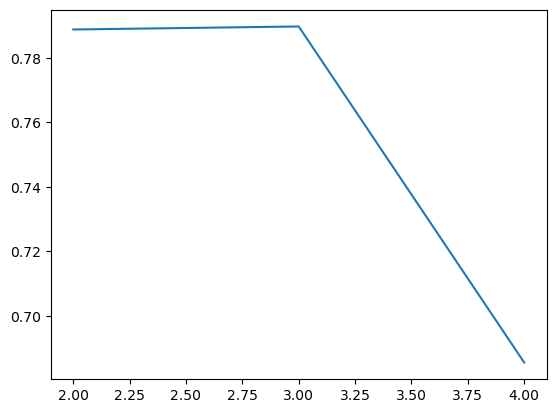

In [71]:
sns.lineplot(x=order, y=r2)

In [27]:
A = [("ploy", PolynomialFeatures(include_bias=False, degree=3)), ("model", LinearRegression())]
Pi = Pipeline(A)
Pi.fit(x_train, y_train)
yhatPi = Pi.predict(x_test)
r2_score(y_test, yhatPi), mean_squared_error(y_test, yhatPi)

(0.7957450927211631, 23771081985.709515)